In [0]:
# This step is just to be able to generate plots when running at colab.research.google.com
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [14]:
# Download the data from the AskNowQA space on gitHub
!curl -O 'https://raw.githubusercontent.com/AskNowQA/LC-QuAD/data/train-data.json'
!curl -O 'https://raw.githubusercontent.com/AskNowQA/LC-QuAD/data/test-data.json'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2056k  100 2056k    0     0  6924k      0 --:--:-- --:--:-- --:--:-- 6924k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  510k  100  510k    0     0  2715k      0 --:--:-- --:--:-- --:--:-- 2729k


In [1]:
'''
Parse the JSON data, splitting it into . The data source already split the data
in to training and test sets; we recombine so that we can perform our own split.

Each entry has the following keys:

  - _id
  - corrected_question
  - intermediary_question
  - sparql_query
  - sparql_template_id

We are interested in corrected_question (the NLQ to be translated) and 
sparql_query (the target for the translations).
'''
import json

with open('train-data.json', 'r', encoding='utf-8') as f:
  train_data = json.load(f)

with open('test-data.json', 'r', encoding='utf-8') as f:
  test_data = json.load(f)
  
source_data = train_data + test_data  
  
# quick inspection
print('\nNumber of records: {}'.format(len(source_data)))
print('\nSample pair of NLQ and SPARQL:\n')
print(source_data[0]['corrected_question'])
print(source_data[0]['sparql_query'])


Number of records: 5000

Sample pair of NLQ and SPARQL:

How many movies did Stanley Kubrick direct?
SELECT DISTINCT COUNT(?uri) WHERE {?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Stanley_Kubrick>  . }


In [2]:
# Split the dataset into the questions (NLQs) and queries (SPARQL)
import numpy as np

questions = [item['corrected_question'] for item in source_data]
queries = [item['sparql_query'] for item in source_data]

assert np.shape(questions) == np.shape(queries)

In [3]:
'''
The questions undergo fuller cleaning than the queries, removing punctuation etc.
The queries are already normalized as they are valid SPARQL statements. Two sets
are made from the queries:

  - input queries, which have a start token prepended to each
  - target queries, which have an end token appended to each

There are a few SPARQL statements where curly braces don't have spaces between them
and neighbouring tokens. We add a space around them if they don't exist.
'''
from keras.preprocessing.text import text_to_word_sequence
from pickle import dump, load
import re

default_filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
START_TOKEN = '<start>'
END_TOKEN = '<end>'

def load_clean_texts(filename):
  with open(filename, 'rb') as f:
    content = load(f)
    print('loaded {}'.format(filename))
    return content

def save_texts(texts, filename):
  with open(filename, 'wb') as f:
    dump(texts, f)
    print('saved {}'.format(filename))

def separate_curly_braces(text):
  return re.sub(r'([^ ])([{}])([^ ])', r'\1 \2 \3', text)

def clean_texts(texts, filename, filters=default_filters, lower=True, 
                start_token=None, end_token=None):
  texts = [separate_curly_braces(text) for text in texts]
  texts = [text_to_word_sequence(text, filters, lower) for text in texts]

  if start_token is not None:
    texts = [[start_token] + text for text in texts]

  if end_token is not None:
    texts = [text + [end_token] for text in texts]
  
  save_texts(texts, filename)

clean_questions = clean_texts(questions, filename='clean_questions.pkl')
clean_query_inputs = clean_texts(queries, filters='', lower=False, start_token=START_TOKEN,
                                 filename='clean_query_inputs.pkl')
clean_query_outputs = clean_texts(queries, filters='', lower=False, end_token=END_TOKEN,
                                  filename='clean_query_outputs.pkl')


Using TensorFlow backend.


saved clean_questions.pkl
saved clean_query_inputs.pkl
saved clean_query_outputs.pkl


loaded clean_questions.pkl
[('the', 5000), ('of', 3279), ('is', 2276), ('which', 1566), ('what', 1206), ('in', 1110), ('and', 889), ('who', 823), ('are', 801), ('by', 720), ('whose', 644), ('name', 489), ('was', 465), ('how', 454), ('a', 454), ('many', 453), ('where', 383), ('have', 372), ('to', 371), ('also', 337), ('list', 332), ('has', 298), ('as', 261), ('for', 255), ('people', 240), ('did', 232), ('team', 206), ('with', 194), ('does', 181), ('some', 163), ('city', 163), ('company', 162), ('one', 160), ('all', 155), ('count', 154), ('place', 151), ('at', 150), ('were', 139), ('been', 137), ('on', 128), ('from', 128), ('river', 121), ('located', 117), ('show', 113), ('television', 112), ('played', 111), ('school', 111), ('music', 107), ('tv', 103), ('country', 103), ('number', 101), ('shows', 99), ('awards', 98), ('movies', 97), ('common', 91), ('me', 89), ('university', 83), ('won', 83), ('person', 82), ('do', 81), ('there', 80), ('state', 79), ('president', 78), ('born', 78), ('gi

(array([7.104e+03, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 5.0090e+02, 1.0008e+03, 1.5007e+03, 2.0006e+03,
        2.5005e+03, 3.0004e+03, 3.5003e+03, 4.0002e+03, 4.5001e+03,
        5.0000e+03]),
 <a list of 10 Patch objects>)

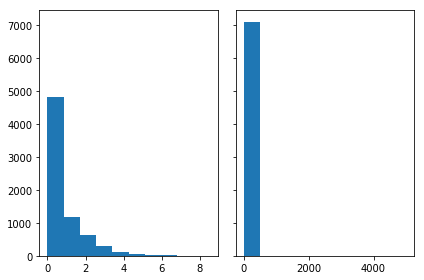

In [27]:
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

clean_questions = load_clean_texts('clean_questions.pkl')

# print(clean_questions)
x = [['how', 'how', 'how', 'many'], ['many', 'are', 'there', 'in', 'the', 'world', 'yes', 'no', 'please', 'very', 'very']]

# print(list(y))
cnt = Counter(chain.from_iterable(clean_questions))
print(cnt.most_common(1))
print(np.log(5000))
prex = np.array(list(cnt.values()))
print(np.max(prex))
x = np.log(prex)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(x, bins=10)
axs[1].hist(cnt.values(), bins=10)

In [0]:
import string
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

class Encoder:
  '''
  Class creates a tokenizer used for vectorizing texts. It can also create a one-hot
  encoded version of the text vectors, which as the target of the predictions.
  '''

  def __init__(self, texts):
    self.texts = texts
    self.tokenizer = Tokenizer()
    self.tokenizer.fit_on_texts(self.texts)
    self.inverter = dict((v, k) for k, v in self.tokenizer.word_index.items())
    self.maxlen = max(len(text) for text in self.texts)
    self.vocab_size = len(self.tokenizer.word_index) + 1    
    self.report()

  def report(self):
    print('---')
    print('vocab size: {}'.format(self.vocab_size))
    print('sequence lengths: {}'.format(self.maxlen))
    print('sample: "{}"'.format(' '.join(self.texts[100])))
    print('word_index:', self.tokenizer.word_index)
    
    sample_word = self.texts[0][0]    
    hot_encoded_sample_word = self.to_categorical(texts=[sample_word.split()], maxlen=1)
    decoded_hot_encoded = self.decode_categorical(one_hot_sequence=hot_encoded_sample_word)
    print('decoded encoded sample word: {}'.format(decoded_hot_encoded))
  
  def encode_text(self, text, pad_to_length):
    return self.encode_texts(texts=[text.split()], maxlen=pad_to_length)
  
  def encode_texts(self, texts, maxlen=None):
    if maxlen is None:
      maxlen = self.maxlen
    sequences = self.tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen, padding='post')

  def encoded(self):
    return self.encode_texts(self.texts)

  def decode_tokens(self, sequence):
    sentence = list()
    for token in sequence:
      if token == 0:
        break
      sentence.append(self.inverter[token])
    return ' '.join(sentence)

  def to_categorical(self, texts, maxlen=None):
    encoded = self.encode_texts(texts, maxlen)
    categorical = [to_categorical(text, num_classes=self.vocab_size) for text in encoded]
    return np.array(categorical).reshape(encoded.shape[0], encoded.shape[1], self.vocab_size)

  def categorical_encoded(self):
    encoded = self.encoded()
    return self.to_categorical(encoded)
          
  def decode_categorical(self, one_hot_sequence):
    sequence = [np.argmax(v) for v in one_hot_sequence]
    return self.decode_tokens(sequence)
   

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
from nltk.translate.bleu_score import corpus_bleu
import re

class QuestionToQuery:
  '''
  Instance of the training + inference models, used as convenience to run 
  different hyperparameters.
  '''

  def __init__(self, latent_dim, epochs, batch_size, optimizer, dropout, recurrent_dropout,
               questions_vocab_size, query_vocab_size, question_length, query_length):

    self.latent_dim = latent_dim
    self.epochs = epochs
    self.batch_size = batch_size
    self.optimizer = optimizer
    self.dropout = dropout
    self.recurrent_dropout = recurrent_dropout
    
    self.questions_vocab_size = questions_vocab_size
    self.query_vocab_size = query_vocab_size
    self.question_length = question_length
    self.query_length = query_length
    dirty_name = 'model_{}_{}_{}_{}_{}_{}'.format(latent_dim, epochs, batch_size, optimizer,
                                                 dropout, recurrent_dropout)
    self.name = re.sub(r'\.', '', dirty_name)
    self.init_training_model()
    self.init_inference_model()
  
  def init_training_model(self):
    '''
    The Training Model trains embedding and LSTM layers, and the encoder state.
    '''
    self.encoder_inputs = Input(shape=(None,))

    x = Embedding(input_dim=self.questions_vocab_size,
                  output_dim=self.latent_dim,
                  mask_zero=True,
                  input_length=self.question_length)
    encoder_embedding_outputs = x(self.encoder_inputs)

    
    x = LSTM(units=self.latent_dim, 
             return_state=True, 
             dropout=self.dropout,
             recurrent_dropout=self.recurrent_dropout)
    _, state_h, state_c = x(encoder_embedding_outputs)
    self.encoder_states = [state_h, state_c]

    self.decoder_inputs = Input(shape=(None,))
    
    x = Embedding(input_dim=self.query_vocab_size,
                  output_dim=self.latent_dim,
                  mask_zero=True,
                  input_length=self.query_length)
    self.decoder_embedding_outputs = x(self.decoder_inputs)

    self.decoder_lstm = LSTM(units=self.latent_dim, return_sequences=True, return_state=True,
                             dropout=0.2, recurrent_dropout=0.2)
    decoder_lstm_outputs, _, _ = self.decoder_lstm(self.decoder_embedding_outputs, 
                                                   initial_state=self.encoder_states)
    
    self.decoder_dense = Dense(units=self.query_vocab_size, activation='softmax')
    decoder_outputs = self.decoder_dense(decoder_lstm_outputs)

    self.training_model = Model(inputs=[self.encoder_inputs, self.decoder_inputs], 
                                outputs=decoder_outputs)
    self.training_model.compile(optimizer=self.optimizer,
                                loss='categorical_crossentropy', 
                                metrics=['accuracy'])

  def init_inference_model(self):
    '''
    Model for generating predictions of SPARQL queries from questions. Uses inputs from
    the training model.
    '''
    self.encoder_model = Model(inputs=self.encoder_inputs, outputs=self.encoder_states)
    encoder_outputs = Input(shape=(None, self.latent_dim))

    input_h = Input(shape=(self.latent_dim,))
    input_c = Input(shape=(self.latent_dim,))
    input_states = [input_h, input_c]

    inference_lstm_outputs, inference_h, inference_c = \
      self.decoder_lstm(self.decoder_embedding_outputs, initial_state=input_states)

    inference_states = [inference_h, inference_c]
    inference_outputs = self.decoder_dense(inference_lstm_outputs)

    self.inference_model = Model([self.decoder_inputs] + input_states,
                                 [inference_outputs] + inference_states)
  
  def summary(self):
    print(self.training_model.summary())
    print(self.encoder_model.summary())
    print(self.inference_model.summary())
    
  def plot_models(self):
    plot_model(training_model, to_file='training_model.png', show_shapes=True)    
    plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)    
    plot_model(inference_model, to_file='inference_model.png', show_shapes=True)
    
  def train(self, questions, query_inputs, query_outputs):
    assert len(questions) == len(query_inputs)
    assert len(query_inputs) == len(query_outputs)
    
    train_X = [questions, query_inputs]
    train_y = query_outputs

    checkpoint = ModelCheckpoint('training_{}.h5'.format(self.name), monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min')
    self.history = self.training_model.fit(x=train_X, y=train_y, 
                                           batch_size=self.batch_size, 
                                           epochs=self.epochs, 
                                           validation_split=0.1,
                                           callbacks=[checkpoint],
                                           verbose=2)
  
  def plot_training(self):
    pyplot.plot(self.history.history['loss'])
    pyplot.plot(self.history.history['val_loss'])
    pyplot.title('Training vs Validation Loss')
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['train', 'val'], loc='upper left')
    pyplot.savefig('loss_{}'.format(self.name))
    pyplot.gcf().clear()

    pyplot.plot(self.history.history['acc'])
    pyplot.plot(self.history.history['val_acc'])
    pyplot.title('Training vs Validation Accuracy')
    pyplot.ylabel('Accuracy')
    pyplot.xlabel('Epoch')
    pyplot.legend(['train', 'val'], loc='upper left')
    pyplot.savefig('accuracy_{}'.format(self.name))
    pyplot.gcf().clear()


In [0]:
class ModelEvaluation:
  '''
  Evaluates the inference model using the BLEU score for 1-4 grams. The evaluation
  is done comparing predictions from questions to target queries 
  '''

  def __init__(self, model, query_inputs_encoder, query_outputs_encoder, query_length):
    self.model = model
    self.query_inputs_encoder = query_inputs_encoder
    self.query_outputs_encoder = query_outputs_encoder
    self.query_length = query_length

  def question_to_query(self, question):
    states_value = self.model.encoder_model.predict(question)   
    inference_input = self.query_inputs_encoder.encode_text(START_TOKEN, 
                                                            pad_to_length=self.query_length)
    decoded_sentence = list()

    while True:
      output_tokens, h, c = self.model.inference_model.predict([inference_input, 
                                                                states_value[0], 
                                                                states_value[1]])
      
      decoded_word = self.query_outputs_encoder.decode_categorical(output_tokens)
      
      if (decoded_word == END_TOKEN or len(decoded_sentence) >= self.query_outputs_encoder.maxlen):
        break

      decoded_sentence.append(decoded_word)
      inference_input = self.query_inputs_encoder.encode_text(decoded_word, 
                                                              pad_to_length=self.query_length)
      states_value = h, c

    return decoded_sentence

  def run(self, questions, target_queries):
    target = list()
    predicted = list()
    for i, question in enumerate(questions):
      target_query = self.query_outputs_encoder.decode_categorical(target_queries[i])
      target.append(target_query.split())

      predicted_query = self.question_to_query(question)
      predicted.append(predicted_query)

      if i < 10:
        print('\nSample translation:')
        print('Question: {}'.format(questions_encoder.decode_tokens(question)))
        print('Target SPARQL: {}'.format(target_query))
        print('Predicted SPARQL: {}'.format(' '.join(predicted_query)))

    bleu_1 = corpus_bleu(target, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(target, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(target, predicted, weights=(0.333, 0.333, 0.333, 0))
    bleu_4 = corpus_bleu(target, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return dict(bleu_1=bleu_1, bleu_2=bleu_2, bleu_3=bleu_3, bleu_4=bleu_4)

In [22]:
'''
6. LOAD CLEAN DATA AND SPLIT IN TO TRAIN AND TEST
'''
from sklearn.model_selection import train_test_split
 
clean_questions = load_clean_texts('clean_questions.pkl')
clean_query_inputs = load_clean_texts('clean_query_inputs.pkl')
clean_query_outputs = load_clean_texts('clean_query_outputs.pkl')

questions_encoder = Encoder(clean_questions)
query_inputs_encoder = Encoder(clean_query_inputs)
query_outputs_encoder = Encoder(clean_query_outputs)

encoded_questions = questions_encoder.encode_texts(clean_questions)
encoded_query_inputs = query_inputs_encoder.encode_texts(clean_query_inputs)
encoded_query_outputs = query_outputs_encoder.to_categorical(clean_query_outputs)

questions_train, questions_test, query_inputs_train, query_inputs_test, query_outputs_train, \
  query_outputs_test = train_test_split(encoded_questions, encoded_query_inputs, 
                                        encoded_query_outputs, test_size=0.1, random_state=9)

---
vocab size: 7116
sequence lengths: 25
sample: "who won a norbert wiener award for social and professional responsibility"
word_index: {'the': 1, 'of': 2, 'is': 3, 'which': 4, 'what': 5, 'in': 6, 'and': 7, 'who': 8, 'are': 9, 'by': 10, 'whose': 11, 'name': 12, 'was': 13, 'how': 14, 'a': 15, 'many': 16, 'where': 17, 'have': 18, 'to': 19, 'also': 20, 'list': 21, 'has': 22, 'as': 23, 'for': 24, 'people': 25, 'did': 26, 'team': 27, 'with': 28, 'does': 29, 'some': 30, 'city': 31, 'company': 32, 'one': 33, 'all': 34, 'count': 35, 'place': 36, 'at': 37, 'were': 38, 'been': 39, 'on': 40, 'from': 41, 'river': 42, 'located': 43, 'show': 44, 'television': 45, 'played': 46, 'school': 47, 'music': 48, 'tv': 49, 'country': 50, 'number': 51, 'shows': 52, 'awards': 53, 'movies': 54, 'common': 55, 'me': 56, 'university': 57, 'won': 58, 'person': 59, 'do': 60, 'there': 61, 'state': 62, 'president': 63, 'born': 64, 'give': 65, 'work': 66, 'play': 67, 'national': 68, 'john': 69, 'famous': 70, 'office':

In [0]:
import itertools

questions_vocab_size = questions_encoder.vocab_size
query_vocab_size = query_inputs_encoder.vocab_size

# hyperparam_sets = itertools.product([64, 128, 256], [15], [32, 64], ['adam', 'rmsprop'])
# 1. [256], [100], [32], ['adam'], [0.5], [0.5]
# 2. [256], [100], [64], ['adam'], [0.5], [0.5]
# 3. [256], [100], [64], ['adam'], [0.0], [0.0]
hyperparam_sets = itertools.product([64], [100], [64], ['adam'], [0.5], [0.5])

for latent_dim, epochs, batch_size, optimizer, dropout, recurrent_dropout in hyperparam_sets:
  print('=' * 100)
  print('Running hyperparameter set: latent_dim: {}, epochs: {}, batch_size: {}, optimizer: {}'
        .format(latent_dim, epochs, batch_size, optimizer))
  
  model = QuestionToQuery(latent_dim=latent_dim, 
                          epochs=epochs,
                          batch_size=batch_size,
                          optimizer=optimizer,
                          dropout=dropout, 
                          recurrent_dropout=recurrent_dropout,
                          questions_vocab_size=questions_vocab_size, 
                          query_vocab_size=query_vocab_size,
                          question_length=questions_encoder.maxlen, 
                          query_length=query_inputs_encoder.maxlen)

  model.train(questions=questions_train, 
              query_inputs=query_inputs_train,
              query_outputs=query_outputs_train)
  model.plot_training()

  evaluation = ModelEvaluation(model=model,
                               query_inputs_encoder=query_inputs_encoder,
                               query_outputs_encoder=query_outputs_encoder,
                               query_length=query_inputs_encoder.maxlen)
  
  training_bleu_scores = evaluation.run(questions=questions_train, 
                                        target_queries=query_outputs_train)
  print('Training BLEU scores: {}\n'.format(training_bleu_scores))
  
  test_bleu_scores = evaluation.run(questions=questions_test, 
                                    target_queries=query_outputs_test)
  print('Test BLEU scores: {}\n'.format(test_bleu_scores))

Running hyperparameter set: latent_dim: 64, epochs: 100, batch_size: 64, optimizer: adam
Train on 4050 samples, validate on 450 samples
Epoch 1/100
 - 51s - loss: 6.7080 - acc: 0.1782 - val_loss: 4.3215 - val_acc: 0.1305

Epoch 00001: val_loss improved from inf to 4.32154, saving model to training_model_64_100_64_adam_05_05.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/100
 - 49s - loss: 4.1746 - acc: 0.1886 - val_loss: 4.1636 - val_acc: 0.2002

Epoch 00002: val_loss improved from 4.32154 to 4.16359, saving model to training_model_64_100_64_adam_05_05.h5
Epoch 3/100
 - 48s - loss: 4.0208 - acc: 0.1804 - val_loss: 4.0615 - val_acc: 0.1784

Epoch 00003: val_loss improved from 4.16359 to 4.06151, saving model to training_model_64_100_64_adam_05_05.h5
Epoch 4/100
 - 48s - loss: 3.9004 - acc: 0.1936 - val_loss: 3.9746 - val_acc: 0.2149

Epoch 00004: val_loss improved from 4.06151 to 3.97464, saving model to training_model_64_100_64_adam_05_05.h5
Epoch 5/100
 - 48s - loss: 3.8046 - acc: 0.2323 - val_loss: 3.9026 - val_acc: 0.2426

Epoch 00005: val_loss improved from 3.97464 to 3.90262, saving model to training_model_64_100_64_adam_05_05.h5
Epoch 6/100
 - 49s - loss: 3.7211 - acc: 0.2656 - val_loss: 3.8381 - val_acc: 0.2782

Epoch 00006: val_loss improved from 3.90262 to 3.83810, saving model to training_model_64_100_64_adam_05_05.h5
Epoch 7/100
 - 

Options to improve (mention or try):

- attention: [Manning NLP Book](https://livebook.manning.com/#!/book/natural-language-processing-in-action/chapter-10/v-10/)
- add accuracy measure (BLEU)
- plot loss and accuracy for increasing epochs
- change dataset size to see if there is a trend improvement
- load existing embeddings: [Using word embeddings](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/6.1-using-word-embeddings.nb.html)
- properly apply dropout: [RNN Regularization](https://arxiv.org/pdf/1409.2329.pdf), [Detailed TF RNN implementation](https://medium.com/@erikhallstrm/using-the-dropout-api-in-tensorflow-2b2e6561dfeb)
- deeper network
- pipeline: entity extract, query categorization, entity order => template binding (query categorization could also return a parameter binding order e.g. 'are there more a than b in c?' => \[qry111, c, a, b\])

Ideas for discussing the method, and some other ideas for improvement: 
 - [TensorFlow NMT Tutorial](https://github.com/tensorflow/nmt#embedding)
 - [A ten-minute introduction to seq2seq in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
